# req

In [1]:
%%capture
!pip install d2l==1.0.3
!pip install comet_ml

In [3]:
%matplotlib inline
import comet_ml
import math
import torch
import gc
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


In [4]:
x = input("Enter project run index: ")
project_name = f"d2l-Chapter9-RNN exercises_{x}"
comet_ml.init(project_name=project_name,
    api_key = 'Gl5ZHraMgo6O2nFTAOhkwFF0s' )




Enter project run index:  sega gpu


COMET INFO: Valid Comet API Key saved in /home/studio-lab-user/.comet.config (set COMET_CONFIG to change where it is saved).


# pre-run code

## #@save

In [5]:
import collections
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
@d2l.add_to_class(d2l.Classifier) #3
def plot_continous(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'

        self.board.xlabel = 'epoch'

        if train:
            x = self.last_x / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.total_epochs
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch

        if 1 : self.board.draw(x, d2l.numpy(d2l.to(value, d2l.cpu())),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

        # Log the loss
        if 1 and hasattr(self, 'experiment_c'):
              self.experiment_c.log_metric( ('train_' if train else 'val_') + key + '_c',
                  d2l.numpy(d2l.to(value, d2l.cpu())), epoch = self.total_epochs )

@d2l.add_to_class(d2l.Classifier)
def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.total_epochs   = self.total_epochs \
                              if hasattr(self,'total_epochs') else 1
        self.epoch_follower = self.epoch_follower \
                              if hasattr(self,'epoch_follower') else 0
        if self.trainer.epoch == 0 and self.epoch_follower != 0:
          self.total_epochs +=1
          self.epoch_follower = 0
        if self.trainer.epoch > self.epoch_follower:
          self.total_epochs+=1
          self.epoch_follower = self.trainer.epoch

        self.xlim_0 = self.xlim_0 if hasattr(self,'xlim_0') else 0
        self.board.xlim = [self.xlim_0, self.total_epochs]

        self.last_x = self.last_x if hasattr(self,'last_x') else 0
        self.plot_continous(key, value, train)
        self.last_x += 1 if train else 0




@d2l.add_to_class(d2l.ProgressBoard)
def draw(self, x, y, label, every_n=1):
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]

        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)

        averaged_point = Point(mean([p.x for p in points]),
                          mean([p.y for p in points]))
        line.append(averaged_point)
        points.clear()
        self.last_point = line[-1]  # Update last_point with the last drawn point

        if not self.display:
            return
        if self.fig is None:
            self.fig, self.ax = plt.subplots(figsize=self.figsize)
        else:
            self.ax.clear()

        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(self.ax.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        if self.xlim: self.ax.set_xlim(self.xlim)
        if self.ylim: self.ax.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        self.ax.set_xlabel(self.xlabel)
        self.ax.set_ylabel(self.ylabel)
        self.ax.set_xscale(self.xscale)
        self.ax.set_yscale(self.yscale)
        self.ax.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)

## Done

In [6]:
class RNNLMScratch(d2l.Classifier):
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
          torch.randn(self.rnn.num_hiddens, self.vocab_size)*self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def log(self, key, value, train):
        # Log the loss
        if 1 and hasattr(self, 'experiment'):
              self.experiment.log_metric( ('train_' if train else 'val_') + key,
                  d2l.numpy(d2l.to(value, d2l.cpu())), epoch = self.trainer.epoch,
                  step = self.trainer.train_batch_idx if train else self.trainer.val_batch_idx )

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        
        lmt = torch.log(torch.tensor([1e4]))
        lmt2 = torch.log(torch.tensor([1]))

        value = lmt if l.item()>lmt or l.item()<lmt2 else l
        #print('FLAG!: ', l, value)
        
        self.plot('ppl', torch.exp(value), train=True)
        self.log('ppl', torch.exp(value), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        
        lmt = torch.log(torch.tensor([1e4]))
        lmt2 = torch.log(torch.tensor([1]))

        value = lmt if l.item()>lmt or l.item()<lmt2 else l
        #print('FLAG!: ', l, value)
        
        
        self.plot('ppl', torch.exp(value), train=False)
        self.log('ppl', torch.exp(value), train=False)




In [7]:
@d2l.add_to_class(RNNLMScratch)  #@
def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)


In [8]:
@d2l.add_to_class(RNNLMScratch)
def forward(self, X, state=None):# input shape: (batch_size, num_steps)
    embs = self.one_hot(X)
    # Output shape: (num_steps, batch_size, vocab_size)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

In [9]:
@d2l.add_to_class(RNNLMScratch)
def output_layer(self, rnn_outputs):
    outputs = [H_t @ self.W_hq + self.b_q for H_t in rnn_outputs]
    #outputs[i] : (batch_size, q/vocab_size/o)
    return torch.stack(outputs, 1) # (batch_size, T, q)


In [10]:
@d2l.add_to_class(d2l.Trainer)
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm


In [11]:
@d2l.add_to_class(RNNLMScratch)
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    #warm-up state
    for i in range(len(prefix)-1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        _, state = self.rnn(embs, state)
        outputs.append(vocab[prefix[i+1]])
    #predict
    for i in range(num_preds):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        rnn_outputs, state = self.rnn(embs, state)
        Y = self.output_layer(rnn_outputs)
        outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])




# to build

## Model

In [12]:
class RNNLM(RNNLMScratch):
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)


### initiate

In [12]:
batch_size,  num_hiddens, num_steps = 1024, 32, 32
lr=1
rnn_type = 'nn.RNN'
rnn_train_type =  'partioning'
gradient_clip_val = 1
data = d2l.TimeMachine(batch_size=batch_size, num_steps=num_steps)
hyper_para = {
    'batch_size': batch_size,
    'num_steps': num_steps,
    'lr': lr,
    'num_hiddens': num_hiddens,
    'rnn_type': rnn_type,
    'rnn_train_type': rnn_train_type,
    'data_vocab_size': len(data.vocab)
}


In [13]:
rnn = nn.RNN(len(data.vocab), num_hiddens)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=lr)
model.board.figsize = (15, 3.5)

random_i = torch.randint(0, 100, size=(1,))[0]
#random_i = 10101
exp_name = f'{lr}{rnn_type}{num_hiddens}{rnn_train_type}{num_steps}_{random_i}'

experiment = comet_ml.Experiment()
experiment.set_name(exp_name)
experiment.log_parameters(hyper_para)


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mohamednaji7/d2l-chapter9-rnn-exercises-sega-gpu-2nd/df597326a6d64fc0873d50bec3f5b0b7

COMET INFO: Couldn't find a Git repository in '/home/studio-lab-user/Untitled Folder' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


### fit

In [14]:
model.experiment = experiment


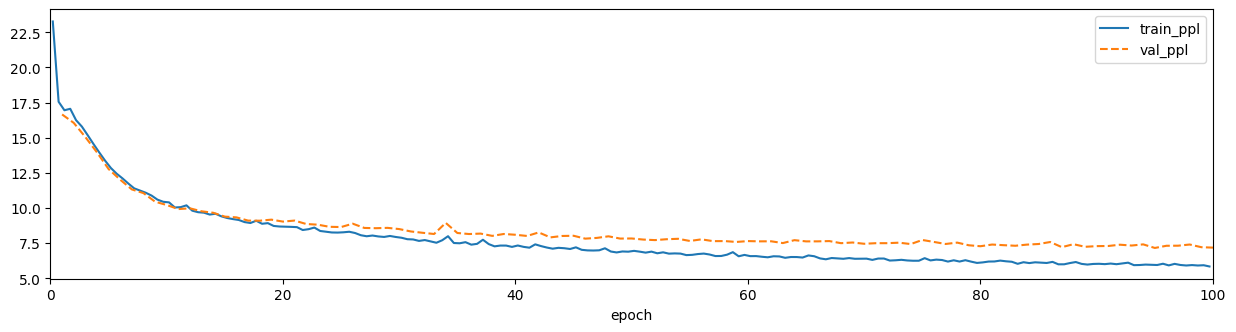

In [15]:
model.xlim_0 = 0

max_epochs = 100
trainer = d2l.Trainer(max_epochs=max_epochs, gradient_clip_val=gradient_clip_val, num_gpus=1)
trainer.fit(model, data)


In [16]:
experiment.log_text(model.predict('it has',     40, data.vocab, d2l.try_gpu()))
experiment.log_text(model.predict('i love you', 25, data.vocab, d2l.try_gpu()))

{'web': 'https://www.comet.com/api/asset/download?assetId=586a1f9a77804d889712873087c6c8d4&experimentKey=df597326a6d64fc0873d50bec3f5b0b7',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=586a1f9a77804d889712873087c6c8d4&experimentKey=df597326a6d64fc0873d50bec3f5b0b7',
 'assetId': '586a1f9a77804d889712873087c6c8d4'}

In [17]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : 1nn.RNN32partioning32_20
COMET INFO:     url                   : https://www.comet.com/mohamednaji7/d2l-chapter9-rnn-exercises-sega-gpu-2nd/df597326a6d64fc0873d50bec3f5b0b7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [201]       : (1.7557423114776611, 3.389176845550537)
COMET INFO:     train_ppl [1000] : (5.787742614746094, 29.641542434692383)
COMET INFO:     val_ppl [500]    : (6.126783847808838, 17.102792739868164)
COMET INFO:   Others:
COMET INFO:     Name : 1nn.RNN32partioning32_20
COMET INFO:   Parameters:
COMET INFO:     batch_size      : 1024
COMET INFO:     data_vocab_size : 28
COMET INFO:     lr              : 1
COMET INFO

In [18]:
model.predict('i love you', 25, data.vocab, d2l.try_gpu())

'i love you the the the the the the '

In [19]:
model.predict('it has', 40, data.vocab, d2l.try_gpu())

'it has and the the the the the the the the the'


## Exercises


### 1. Run the code in this section without clipping the gradient. What happens?

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : without clipping 90
COMET INFO:     url                   : https://www.comet.com/mohamednaji7/d2l-chapter9-rnn-exercises-sega-gpu-2nd/1633f0cf68d84ff8ac20532179b7d2ad
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [201]       : (1.7533968687057495, 3.373371124267578)
COMET INFO:     train_ppl [1000] : (5.700375080108643, 29.176719665527344)
COMET INFO:     val_ppl [500]    : (6.13746976852417, 17.239463806152344)
COMET INFO:   Others:
COMET INFO:     Name : without clipping 90
COMET INFO:   Parameters:
COMET INFO:     batch_size      : 1024
COMET INFO:     data_vocab_size : 28
COMET INFO:     lr              : 1
COMET INFO:     num_h

'i love you and the the the the the '

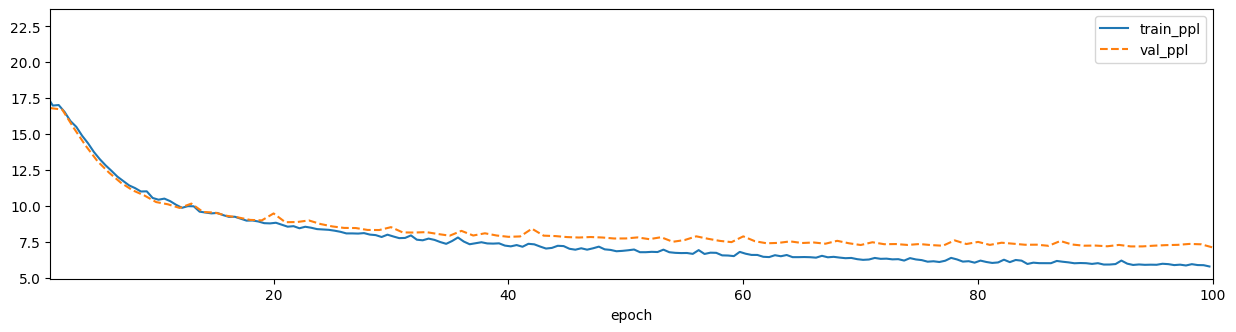

In [20]:
batch_size,  num_hiddens, num_steps = 1024, 32, 32
lr=1
rnn_type = 'nn.RNN'
rnn_train_type =  'partioning'
gradient_clip_val = 0
data = d2l.TimeMachine(batch_size=batch_size, num_steps=num_steps)
hyper_para = {
    'batch_size': batch_size,
    'num_steps': num_steps,
    'lr': lr,
    'num_hiddens': num_hiddens,
    'rnn_type': rnn_type,
    'rnn_train_type': rnn_train_type,
    'data_vocab_size': len(data.vocab)
}

rnn = nn.RNN(len(data.vocab), num_hiddens)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=lr)

random_i = torch.randint(0, 100, size=(1,))[0]
#random_i = 1022
exp_name = "without clipping"
exp_name = f'{exp_name} {random_i}'
experiment = comet_ml.Experiment()
experiment.set_name(exp_name)
experiment.log_parameters(hyper_para)
model.experiment = experiment

model.xlim_0 = 1

model.board.figsize = (15, 3.5)


max_epochs = 100
trainer = d2l.Trainer(max_epochs=max_epochs, gradient_clip_val=gradient_clip_val, num_gpus=1)
trainer.fit(model, data)

experiment.log_text(model.predict('it has',     40, data.vocab, d2l.try_gpu()))
experiment.log_text(model.predict('i love you', 25, data.vocab, d2l.try_gpu()))

experiment.end()

model.predict('it has', 40, data.vocab, d2l.try_gpu())
model.predict('i love you', 25, data.vocab, d2l.try_gpu())

In [21]:

model.predict('it has', 40, data.vocab, d2l.try_gpu())


'it has and the the the the the the the the the'

### 1. Replace the activation function used in this section with ReLU and repeat the experiments in this section. Do we still need gradient clipping? Why?

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : 1nn.RNN_relu32partioning32_1
COMET INFO:     url                   : https://www.comet.com/mohamednaji7/d2l-chapter9-rnn-exercises-sega-gpu-2nd/209921f815d741a28a3fbdf576128c0f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [201]       : (1.7952558994293213, 3.3841323852539062)
COMET INFO:     train_ppl [1000] : (5.978205680847168, 29.49239158630371)
COMET INFO:     val_ppl [500]    : (6.4198808670043945, 18.528310775756836)
COMET INFO:   Others:
COMET INFO:     Name : 1nn.RNN_relu32partioning32_1
COMET INFO:   Parameters:
COMET INFO:     batch_size      : 1024
COMET INFO:     data_vocab_size : 28
COMET INFO:     lr              : 1
C

'i love you the time the time travel'

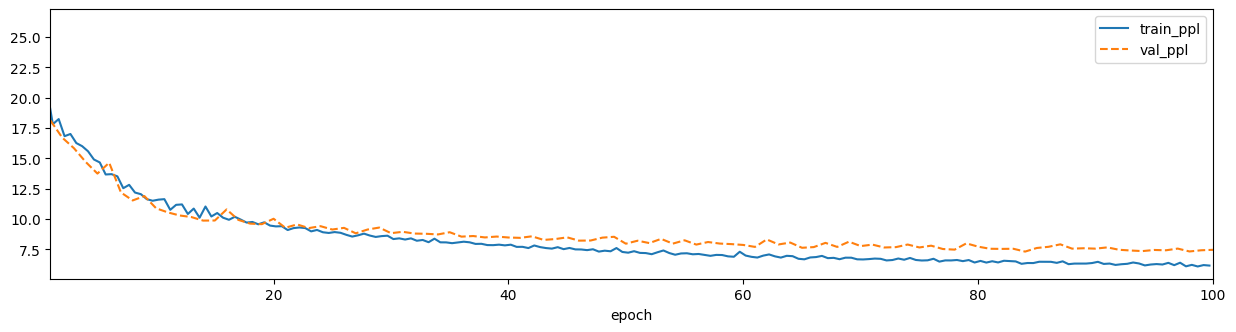

In [22]:
batch_size,  num_hiddens, num_steps = 1024, 32, 32
lr=1
rnn_type = 'nn.RNN_relu'
rnn_train_type =  'partioning'
gradient_clip_val = 0
data = d2l.TimeMachine(batch_size=batch_size, num_steps=num_steps)
hyper_para = {
    'batch_size': batch_size,
    'num_steps': num_steps,
    'lr': lr,
    'num_hiddens': num_hiddens,
    'rnn_type': rnn_type,
    'rnn_train_type': rnn_train_type,
    'data_vocab_size': len(data.vocab)
}

rnn = nn.RNN(len(data.vocab), num_hiddens, nonlinearity='relu')

model = RNNLM(rnn, vocab_size=len(data.vocab), lr=lr)

random_i = torch.randint(0, 100, size=(1,))[0]
#random_i = 1022
exp_name = f'{lr}{rnn_type}{num_hiddens}{rnn_train_type}{num_steps}_{random_i}'

experiment = comet_ml.Experiment()
experiment.set_name(exp_name)
experiment.log_parameters(hyper_para)
model.experiment = experiment

model.xlim_0 = 1

model.board.figsize = (15, 3.5)


max_epochs = 100
trainer = d2l.Trainer(max_epochs=max_epochs, gradient_clip_val=gradient_clip_val, num_gpus=1)
trainer.fit(model, data)

experiment.log_text(model.predict('it has',     40, data.vocab, d2l.try_gpu()))
experiment.log_text(model.predict('i love you', 25, data.vocab, d2l.try_gpu()))

experiment.end()

model.predict('it has', 40, data.vocab, d2l.try_gpu())
model.predict('i love you', 25, data.vocab, d2l.try_gpu())

In [23]:
model.predict('it has', 40, data.vocab, d2l.try_gpu())


'it has and the time traveller the time the tim'

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : 1nn.RNN_clip1_relu32partioning32_45
COMET INFO:     url                   : https://www.comet.com/mohamednaji7/d2l-chapter9-rnn-exercises-sega-gpu-2nd/11b3c6e6b9f647048d5f551ddbcf070a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [201]       : (1.7638447284698486, 3.310131549835205)
COMET INFO:     train_ppl [1000] : (5.719649314880371, 27.38872718811035)
COMET INFO:     val_ppl [500]    : (6.147251129150391, 17.752702713012695)
COMET INFO:   Others:
COMET INFO:     Name : 1nn.RNN_clip1_relu32partioning32_45
COMET INFO:   Parameters:
COMET INFO:     batch_size      : 1024
COMET INFO:     data_vocab_size : 28
COMET INFO:     lr       

'i love you the time traveller and t'

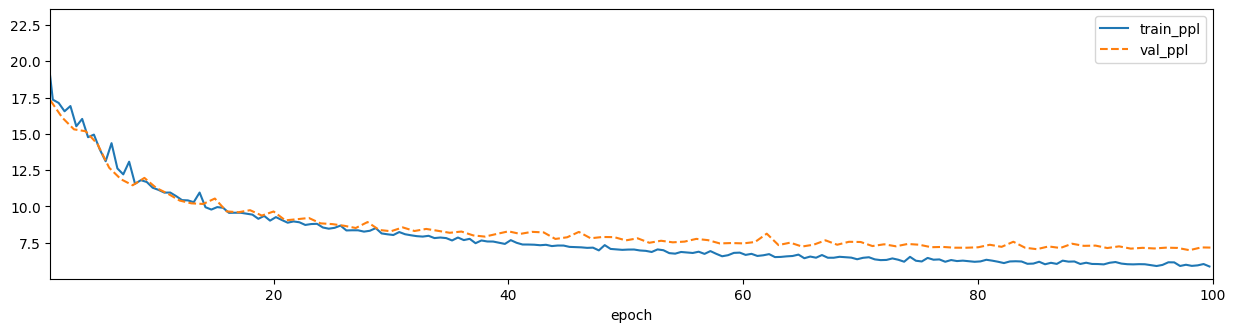

In [24]:
batch_size,  num_hiddens, num_steps = 1024, 32, 32
lr=1
rnn_type = 'nn.RNN_clip1_relu'
rnn_train_type =  'partioning'
gradient_clip_val = 1
data = d2l.TimeMachine(batch_size=batch_size, num_steps=num_steps)
hyper_para = {
    'batch_size': batch_size,
    'num_steps': num_steps,
    'lr': lr,
    'num_hiddens': num_hiddens,
    'rnn_type': rnn_type,
    'rnn_train_type': rnn_train_type,
    'data_vocab_size': len(data.vocab)
}

rnn = nn.RNN(len(data.vocab), num_hiddens, nonlinearity='relu')

model = RNNLM(rnn, vocab_size=len(data.vocab), lr=lr)

random_i = torch.randint(0, 100, size=(1,))[0]
#random_i = 1022
exp_name = f'{lr}{rnn_type}{num_hiddens}{rnn_train_type}{num_steps}_{random_i}'

experiment = comet_ml.Experiment()
experiment.set_name(exp_name)
experiment.log_parameters(hyper_para)
model.experiment = experiment

model.xlim_0 = 1

model.board.figsize = (15, 3.5)


max_epochs = 100
trainer = d2l.Trainer(max_epochs=max_epochs, gradient_clip_val=gradient_clip_val, num_gpus=1)
trainer.fit(model, data)

experiment.log_text(model.predict('it has',     40, data.vocab, d2l.try_gpu()))
experiment.log_text(model.predict('i love you', 25, data.vocab, d2l.try_gpu()))

experiment.end()

model.predict('it has', 40, data.vocab, d2l.try_gpu())
model.predict('i love you', 25, data.vocab, d2l.try_gpu())

In [25]:
model.predict('it has', 40, data.vocab, d2l.try_gpu())


'it has and and and and and and and and and and'

### 1. Adjust the hyperparameters (e.g., number of epochs, number of hidden units, number of time steps in a minibatch, and learning rate) to improve the perplexity. How low can you go while sticking with this simple architecture?

In [13]:
d2l.TimeMachine(10, 1).X.shape[0]

173427

In [14]:
5000/10000

0.5

In [15]:
num_steps  = {'type': 'integer', 'min': 1, 'scaling_type': 'uniform', 'max': 100}
batch_size = {"type": "discrete", "values": [512, 1024, 512*3,  1024*2]}
activation = {"type": "categorical", "values": ["relu", "tanh"]}
num_hiddens = {"type": "discrete", "values": [32, 64, 128, 256, 512, 1024]}
lr = {"type": "integer", "min": 0.1, "scaling_type": "uniform", "max": 1.0}
gradient_clip_val = {"type": "integer", "min": 0.0, "scaling_type": "uniform", "max": 3.0}
num_val = {'type': 'integer', 'min': 5000, 'scaling_type': 'uniform', 'max': 10000}
num_train = {'type': 'integer', 'min': 10000, 'scaling_type': 'uniform', 'max': d2l.TimeMachine(10, 1).X.shape[0] - num_val['max']}

# Define the configuration dictionary
hyperparams = {
    'num_steps': num_steps,
    'batch_size': batch_size,
    'activation': activation,
    'num_hiddens': num_hiddens,
    'lr': lr,
    'gradient_clip_val': gradient_clip_val,
    'num_val': num_val,
    'num_train': num_train
}

x = 3*len(num_hiddens['values']) * len(batch_size['values']) * \
 (num_steps['max'] -  num_steps['min'] )/20 * len(activation['values']) * \
 (num_train['max'] -  num_train['min'] )/100 *  (num_val['max'] -  num_val['min'] )/10000
x, 0.1*x

(546813.828, 54681.3828)

In [16]:
num_train['max'], num_val['max'] / num_train['max'] *100

(163427, 6.118939954842223)

In [17]:

len(hyperparams)

8

In [18]:
128 * num_train['max'] / batch_size['values'][0]

40856.75

In [19]:
# Set the spec for the Bayes Optimization algorithm
spec = {
    "maxCombo": 0, # chatgpt: 50, comet: 20
    # Use default of 10 times the number of hyperparameters


    "objective": "minimize",

    "metric": "opt_val_ppl",
    # The metric name that you are logging and want to minimize or maximize (default loss).

    "minSampleSize": 500, #chatpgt 150, default 100, comet exmaple :500
    # Rule of thumb (5-10 times the number of hyperparameters):
    # Suggested minSampleSize: Between 20 and 40.
    # Considering the large search space, we can use a small fraction, e.g., 1% of 7200.
    #Suggested minSampleSize: Around 70.
    #
    # The algorithm uses minSampleSize to gather initial data.
    # If set to 150, it evaluates 150 different configurations
    # to understand the performance landscape.
    # BEFORE MAKING MORE REFINED AND TARGETED SEARCHES.
    #

    "retryLimit": 25, #default : 20. chatgpt: 25
    # During the optimization process,
    # if the algorithm generates a configuration that has already been evaluated,
    # it will try up to retryLimit times (25 in this case)
    # to come up with a new, unique configuration.

    "retryAssignLimit": 0, # chatgpt: ,  default: 0
    # If an experiment fails or is incomplete,
    # the algorithm will reassign it up to retryAssignLimit times
    # (5 in this case) to ensure it eventually gets completed.
}


In [20]:
# defining the configuration dictionary
config_dict = {"algorithm": "bayes",
               "spec": spec,
               "parameters": hyperparams,
               "name": "Bayes Optimization_i7i",
               "trials": 1}

In [21]:
#project_name = 'draft'
opt = comet_ml.Optimizer(project_name=project_name,
                config = config_dict)

COMET WARNING: Passing Experiment through Optimizer constructor is deprecated; pass them to Optimizer.get_experiments or Optimizer.next
COMET INFO: 759e58fdd575456d9d4598dadc9da81f
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': '759e58fdd575456d9d4598dadc9da81f', 'lastUpdateTime': None, 'maxCombo': 0, 'name': 'Bayes Optimization_i7i', 'parameters': {'activation': {'type': 'categorical', 'values': ['relu', 'tanh']}, 'batch_size': {'type': 'discrete', 'values': [512, 1024, 1536, 2048]}, 'gradient_clip_val': {'max': 3.0, 'min': 0.0, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'integer'}, 'lr': {'max': 1.0, 'min': 0.1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'integer'}, 'num_hiddens': {'type': 'discrete', 'values': [32, 64, 128, 256, 512, 1024]}, 'num_steps': {'max': 100, 'min': 1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'integer'}, 'num_train': {'max': 163427, 'min'

In [22]:
def get_variables(experiment):
        batch_size = experiment.get_parameter("batch_size")
        num_hiddens = experiment.get_parameter("num_hiddens")
        num_steps = experiment.get_parameter("num_steps")
        activation = experiment.get_parameter("activation")
        lr = experiment.get_parameter("lr")
        gradient_clip_val = experiment.get_parameter("gradient_clip_val")
        num_train = experiment.get_parameter("num_train")
        num_val = experiment.get_parameter("num_val")

        data = d2l.TimeMachine(batch_size, num_steps, num_train, num_val)

        rnn_type = f'nn.RNN_clip{gradient_clip_val}_relu'
        rnn_train_type =  'partioning'
        remaining_para = {
        'rnn_type': rnn_type,
        'rnn_train_type': rnn_train_type,
        'data_vocab_size': len(data.vocab),
        }
        random_i = torch.randint(0, 100, size=(1,))[0]
        exp_name = f'{lr}{rnn_type}{num_hiddens}{rnn_train_type}{num_steps}_rand{random_i}'

        return gradient_clip_val, data, batch_size, num_hiddens, num_steps, activation, lr, remaining_para, exp_name

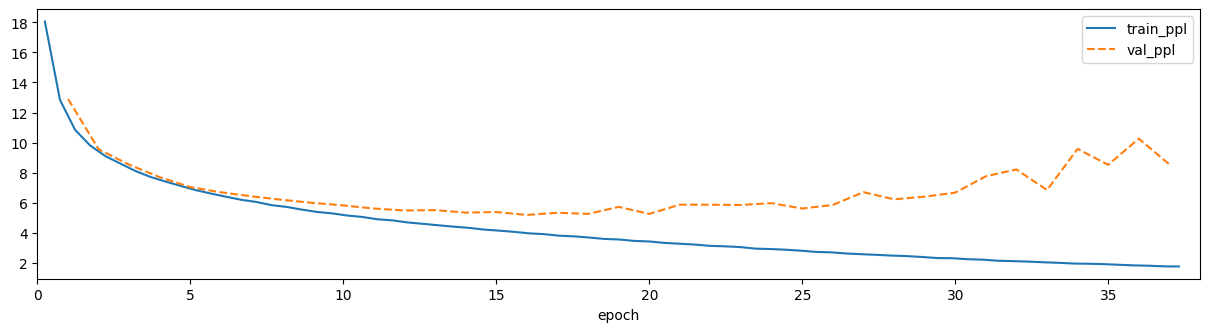

In [ ]:
max_epochs = 128
torch.manual_seed(0)
mean = lambda x: sum(x) / len(x)
for experiment in opt.get_experiments():

    gradient_clip_val, data, batch_size, num_hiddens, num_steps, activation, lr,\
    remaining_para, exp_name = get_variables(experiment)

    rnn = nn.RNN(len(data.vocab), num_hiddens, nonlinearity=activation)
    model = RNNLM(rnn, vocab_size=len(data.vocab), lr=lr)
    model.experiment = experiment
    model.board.figsize = (15, 3.5)

    experiment.log_parameters(remaining_para)
    experiment.set_name(exp_name)

    trainer = d2l.Trainer(max_epochs=max_epochs, gradient_clip_val=gradient_clip_val, num_gpus=1)
    trainer.fit(model, data)


    val_ppl_last5p = mean([ p.y for p in model.board.data['val_ppl'][-int(max_epochs*0.05):] ])
    experiment.log_metric("opt_val_ppl",  val_ppl_last5p )
    
    
    experiment.log_text(model.predict('it has',     40, data.vocab, d2l.try_gpu()))
    experiment.log_text(model.predict('i love you', 25, data.vocab, d2l.try_gpu()))
    experiment.end()
    gc.collect()
    torch.cuda.empty_cache()
    del model


### 1. Replace one-hot encoding with learnable embeddings. Does this lead to better performance?




### h  


1. Conduct another experiment to evaluate the perplexity of this model
   on books written by other authors.

1. Conduct an experiment to determine how well this language model
   trained on *The Time Machine* works on other books by H. G. Wells,
   e.g., *The War of the Worlds*.

### complex arch

In [ ]:
rnn = nn.RNN(len(data.vocab), num_hiddens, nonlinearity='relu', num_layers =
             )

In [ ]:
batch_size,  num_hiddens, num_steps = 1024, 32, 32
lr=1
gradient_clip_val = 0

rnn_type = f'nn.RNN_clip{gradient_clip_val}_relu'
rnn_train_type =  'partioning'
data = d2l.TimeMachine(batch_size=batch_size, num_steps=num_steps)
hyper_para = {
    'batch_size': batch_size,
    'num_steps': num_steps,
    'lr': lr,
    'num_hiddens': num_hiddens,
    'rnn_type': rnn_type,
    'rnn_train_type': rnn_train_type,
    'data_vocab_size': len(data.vocab)
}

rnn = nn.RNN(len(data.vocab), num_hiddens, nonlinearity='relu')

model = RNNLM(rnn, vocab_size=len(data.vocab), lr=lr)

random_i = torch.randint(0, 100, size=(1,))[0]
#random_i = 1022
exp_name = f'{lr}{rnn_type}{num_hiddens}{rnn_train_type}{num_steps}_{random_i}'

experiment = comet_ml.Experiment()
experiment.set_name(exp_name)
experiment.log_parameters(hyper_para)
model.board.experiment = experiment


model.xlim_0 = 1

model.board.figsize = (15, 3.5)


max_epochs = 100
trainer = d2l.Trainer(max_epochs=max_epochs, gradient_clip_val=gradient_clip_val, num_gpus=1)
trainer.fit(model, data)
experiment.end()

model.predict('it has', 40, data.vocab, d2l.try_gpu())
model.predict('i love you', 25, data.vocab, d2l.try_gpu())

### 1. Inserting and Continous state by passing the data.X not to the model but coding it all the way through

## Testy!

In [ ]:
batch_size,  num_hiddens, num_steps = 32, 32, 32
lr=1
gradient_clip_val = 0
data = d2l.TimeMachine(batch_size=batch_size, num_steps=num_steps)


rnn = nn.RNN(len(data.vocab), num_hiddens)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=lr)

max_epochs = 12
trainer = d2l.Trainer(max_epochs=max_epochs, gradient_clip_val=gradient_clip_val, num_gpus=1)
trainer.fit(model, data)
data.X.shape[0], data.num_train, data.num_val